# Проект: Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv. Скачать датасет
- /datasets/geo_data_1.csv. Скачать датасет
- /datasets/geo_data_2.csv. Скачать датасет


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li>
        <li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li>
        <li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li>
        <li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span>
        <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li>
        <li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li>
    </ul>
</div>

## Загрузка и подготовка данных

In [1]:
#подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#подгружаем данные
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#пишем функцию осмотра датасета
def dataset_describer(dataset, dataset_number):
    print("""
{0}. Проводим осмотр датасета №{1}:""".format(dataset_number+1, dataset_number))
    print("""
a. Посмотрим на первые пять строк для месторождения №{0}""".format(dataset_number))
    print(dataset.head())
    print("""
b. Структурная информация по данным месторождения №{0}""".format(dataset_number))
    print(dataset.info()) 
    print("""
c. Статистическая информация по данным месторождения №{0}""".format(dataset_number))
    print(dataset.describe())
    print("""
Количество дубликатов для данных месторождения №{0} равно: {1}""".format(dataset_number, dataset.duplicated().sum()))
    print("""
Количество пропусков для данных месторождения №{0} равно:
{1}""".format(dataset_number, dataset.isna().sum()))

In [4]:
dataset_describer(df0, 0)
dataset_describer(df1, 1)
dataset_describer(df2, 2)


1. Проводим осмотр датасета №0:

a. Посмотрим на первые пять строк для месторождения №0
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

b. Структурная информация по данным месторождения №0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

c. Статистическая информация по данным месторождения №0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419  

- Каждый датасет (отдельно взятый регион) содержит 100 000 наблюдений. Пропусков, дубликатов нет. Формат данных корректен. 

- По целевому признаку product среднеквадратическое отклонение примерно равны, минимумы = 0, максимумы для 0 и 2 месторождения примерно равны, а по месторождению 1 ниже. Также среднее и медианы для месторождений 0 и 2 примерно равны, а по месторождению 1 среднее больше медианы.

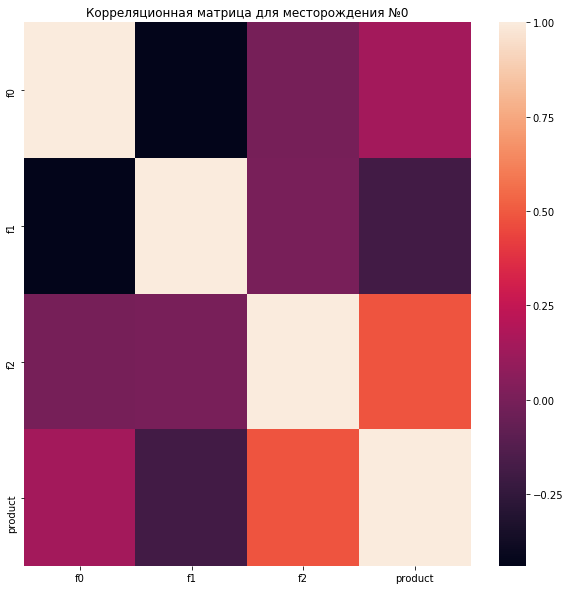

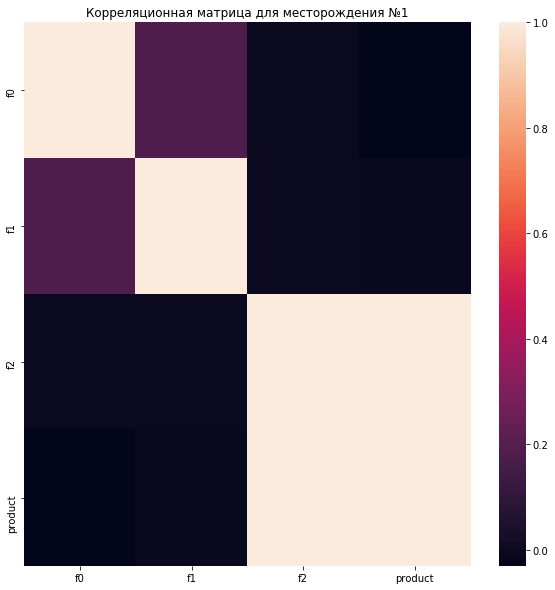

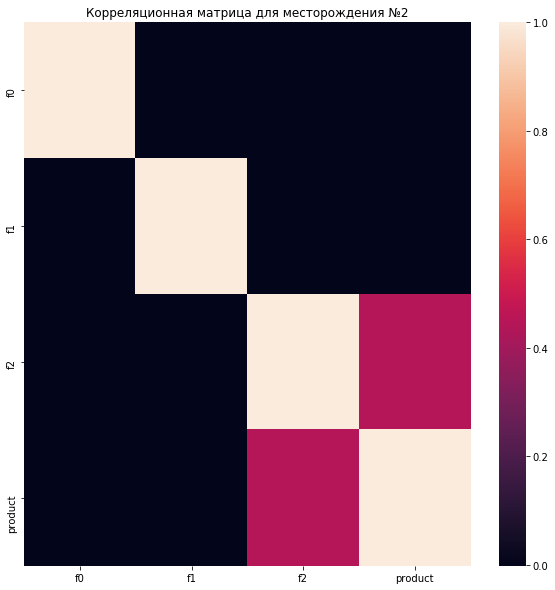

In [5]:
#функция корреляционной матрицы
def heatmap_builder(df, df_number):
    plt.figure(figsize=(10,10))
    plt.title('Корреляционная матрица для месторождения №{0}'.format(df_number))
    sns.heatmap(df.corr());
    plt.show()
    
heatmap_builder(df0, 0)
heatmap_builder(df1, 1)
heatmap_builder(df2, 2)

Заметна корреляция между признаком f2 и целевым признаком product. Между признаками f0 f1 f2 корреляция незначительна. Для месторождение №1 - околоединичная положительная корреляция между f2-product.

In [6]:
#функция построения графиков
def hist_builder(data_column, label, bins):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(20,10))
    axes[0].set_title("Плотность распределения для параметра: " + label, fontsize=20)
    axes[0].set_ylabel("Плотность параметра: " + label, fontsize=18)
    axes[0].set_xlabel("Параметр: " + label, fontsize=18)
    sns.distplot(data_column, axlabel="Параметр: " + label, bins=bins, ax=axes[0])
    
    axes[1].set_title("Boxplot для параметра: " + label, fontsize=18)
    axes[1].set_xlabel("Параметр: " + label, fontsize=18)
    sns.boxplot(data=data_column, orient='h', ax=axes[1])
    plt.show()
#функция анализа аномалий
def anomaly_detection(data_column, label):
    anomaly_threshold_up = data_column.quantile(0.75) + (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_threshold_down = data_column.quantile(0.25) - (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_percent = round(len(data_column[(data_column > anomaly_threshold_up) | (data_column < anomaly_threshold_down)]) / len(data_column) * 100, 2)
    print("Доля выбросов параметра " + label + " равно: " + str(anomaly_percent) + "%")
    
#итоговая функция
def check_param(bins, dataset, dataset_num):
    print("Анализ параметров датасета №{0}:".format(dataset_num))
    for column in ['f0', 'f1', 'f2', 'product']:
        print("Анализ параметра '" + column + "':")
        hist_builder(dataset[column], column, bins)
        anomaly_detection(dataset[column], column)


Анализ параметров датасета №0:
Анализ параметра 'f0':


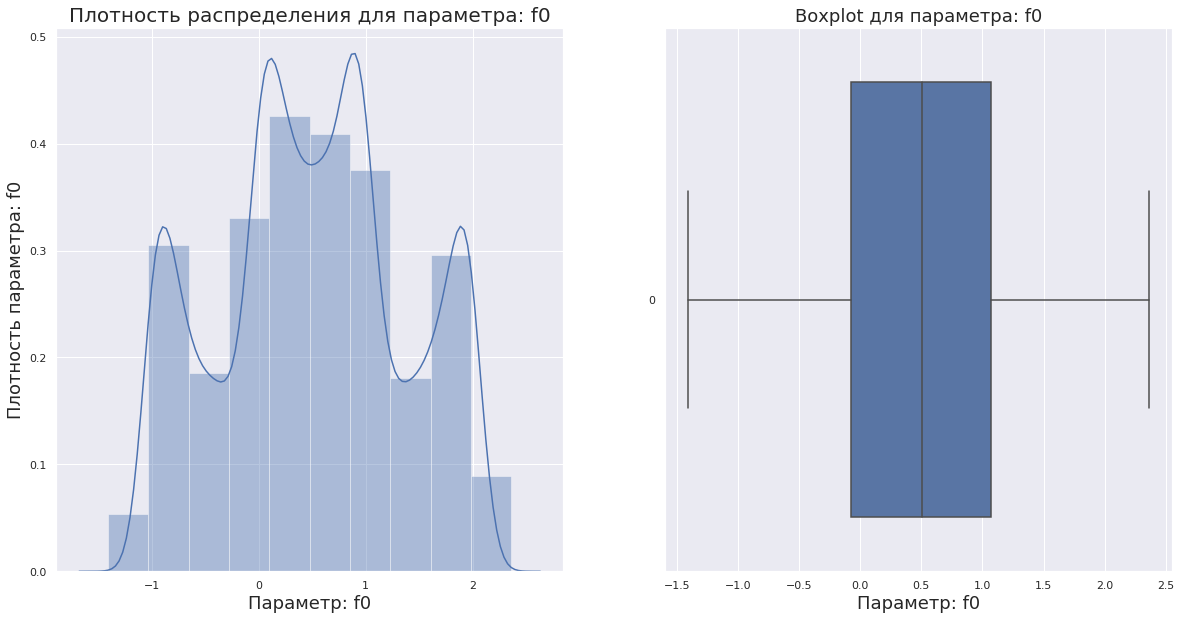

Доля выбросов параметра f0 равно: 0.0%
Анализ параметра 'f1':


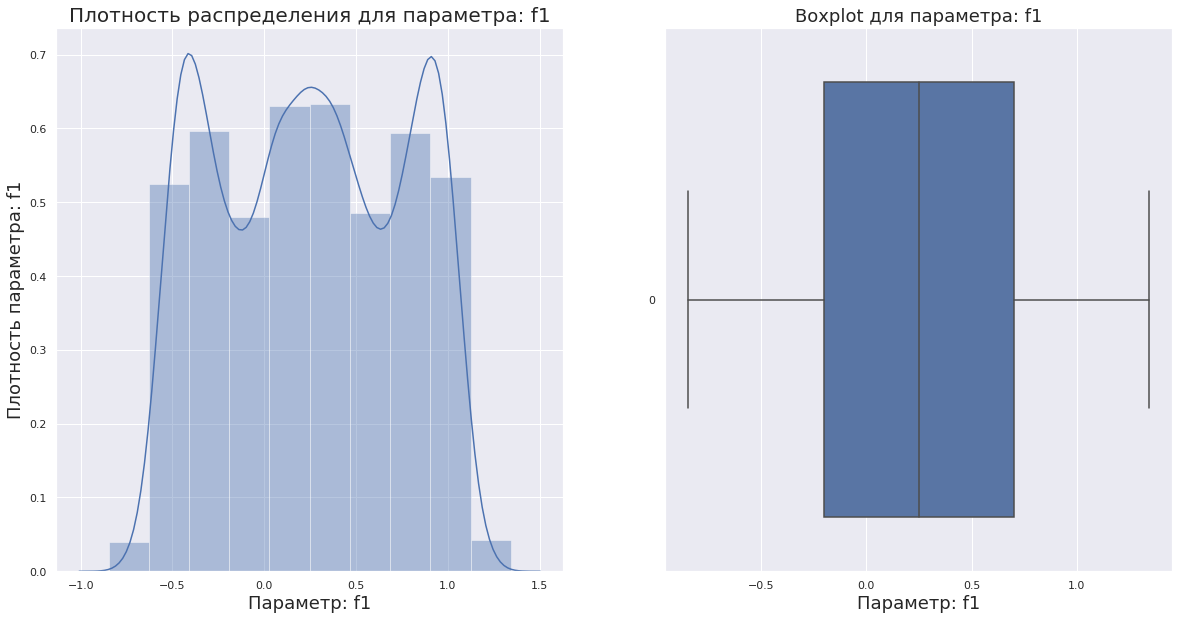

Доля выбросов параметра f1 равно: 0.0%
Анализ параметра 'f2':


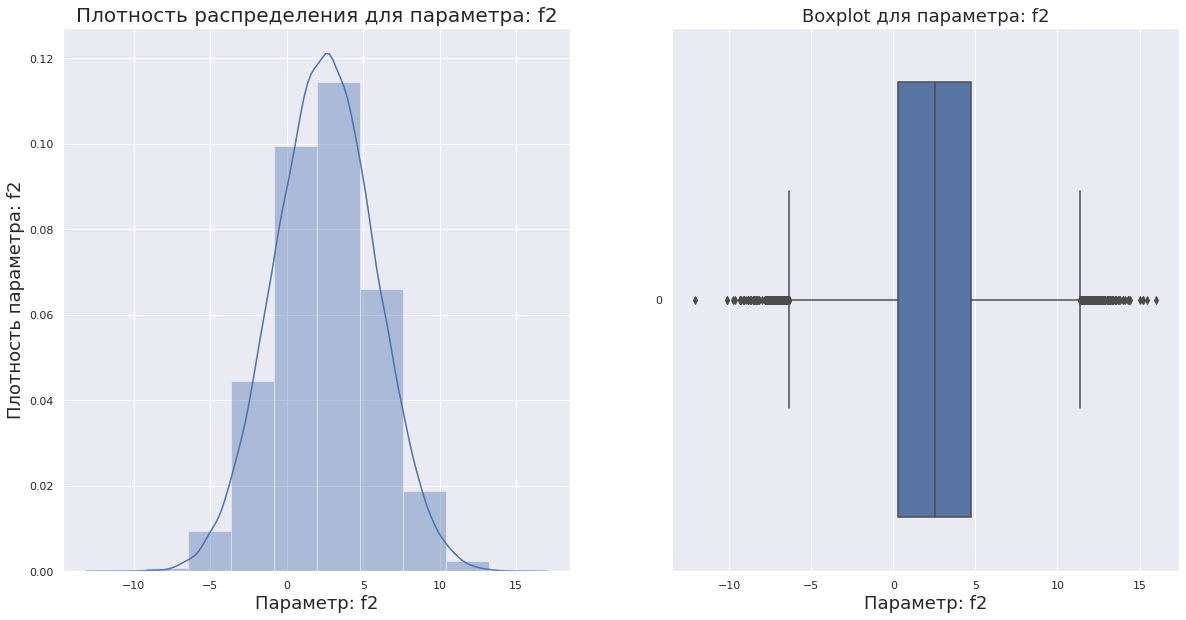

Доля выбросов параметра f2 равно: 0.51%
Анализ параметра 'product':


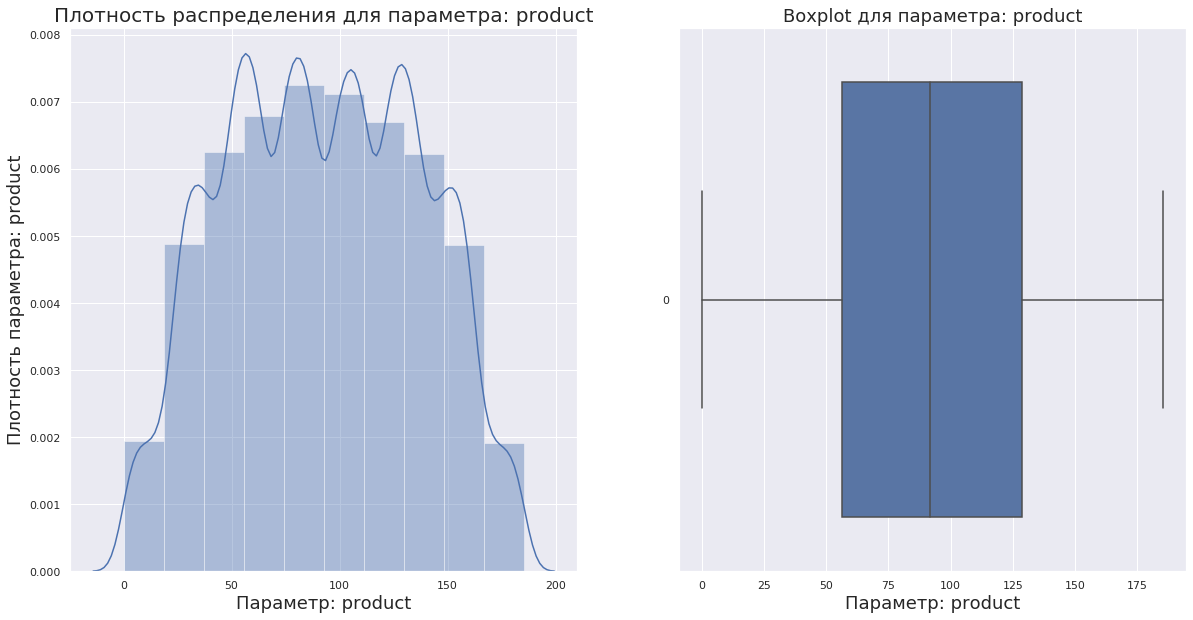

Доля выбросов параметра product равно: 0.0%
Анализ параметров датасета №1:
Анализ параметра 'f0':


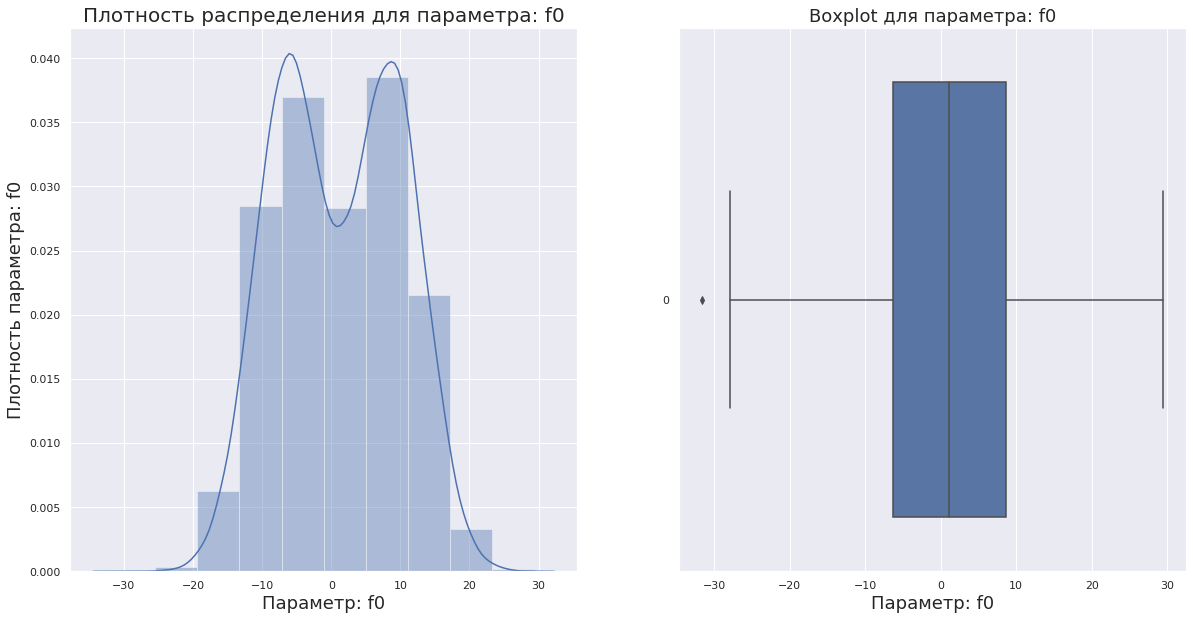

Доля выбросов параметра f0 равно: 0.0%
Анализ параметра 'f1':


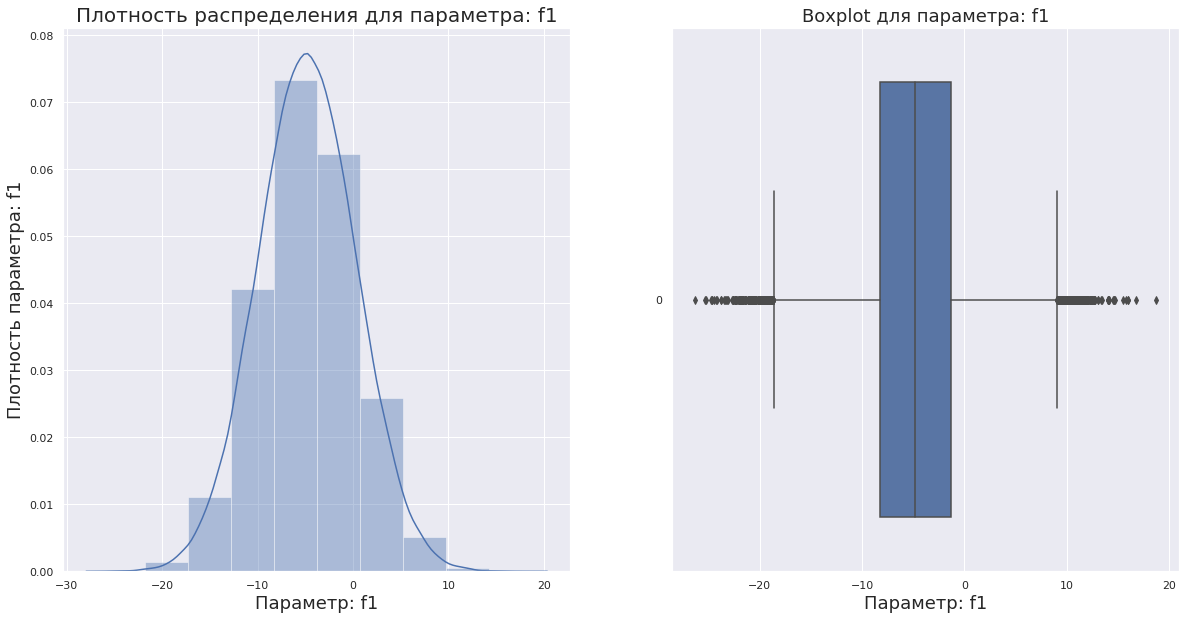

Доля выбросов параметра f1 равно: 0.64%
Анализ параметра 'f2':


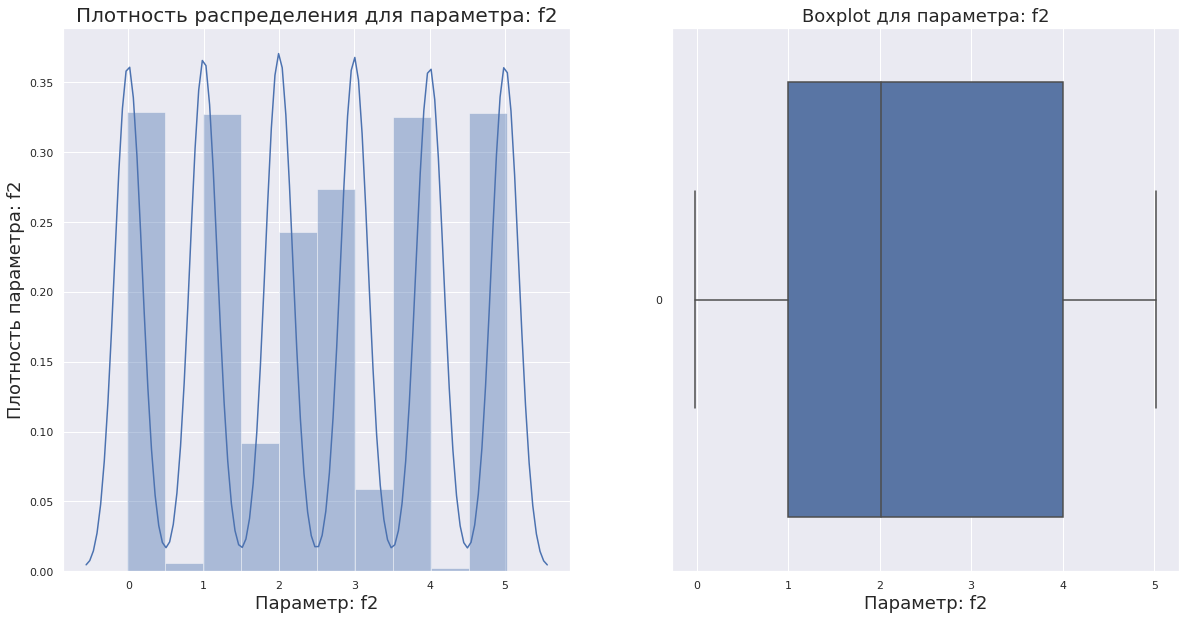

Доля выбросов параметра f2 равно: 0.0%
Анализ параметра 'product':


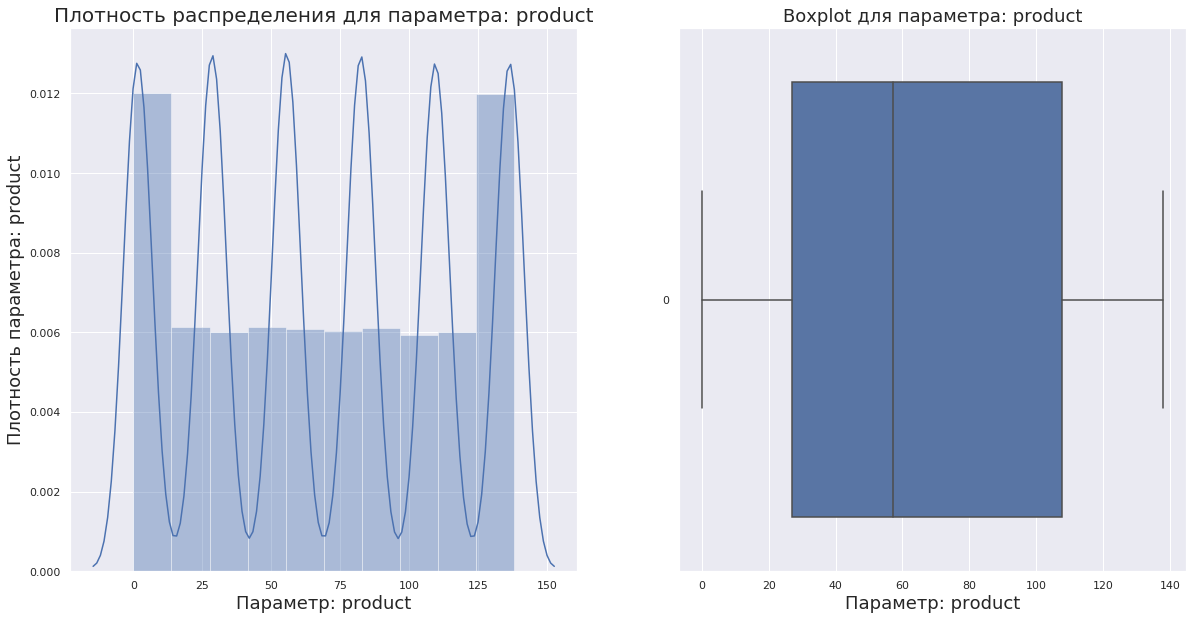

Доля выбросов параметра product равно: 0.0%
Анализ параметров датасета №2:
Анализ параметра 'f0':


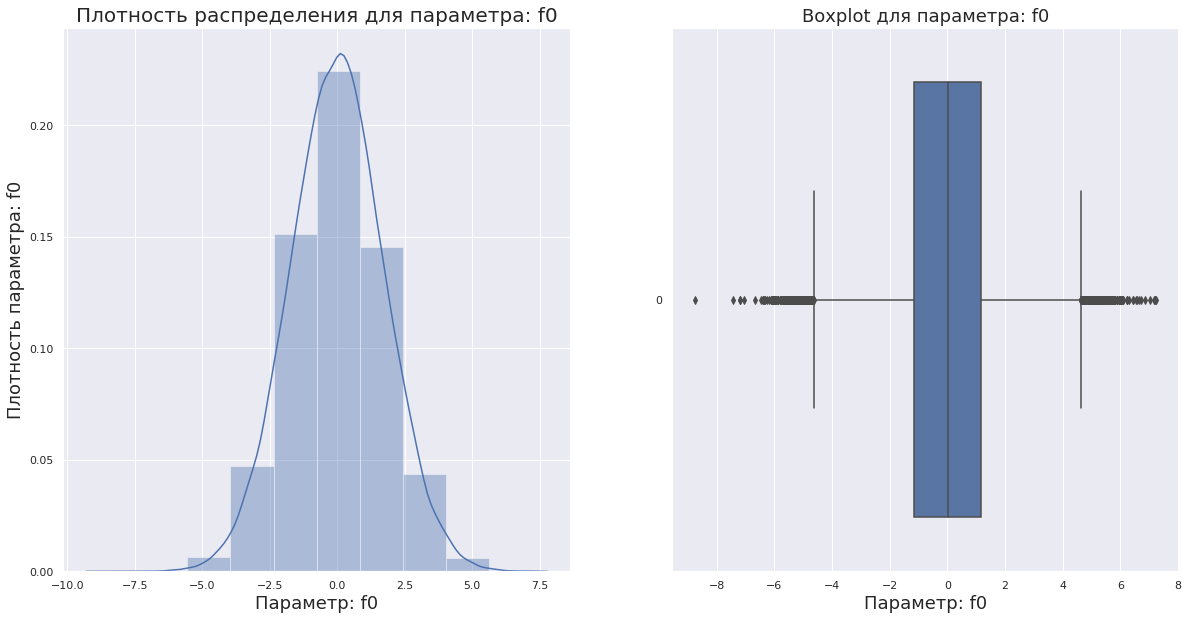

Доля выбросов параметра f0 равно: 0.73%
Анализ параметра 'f1':


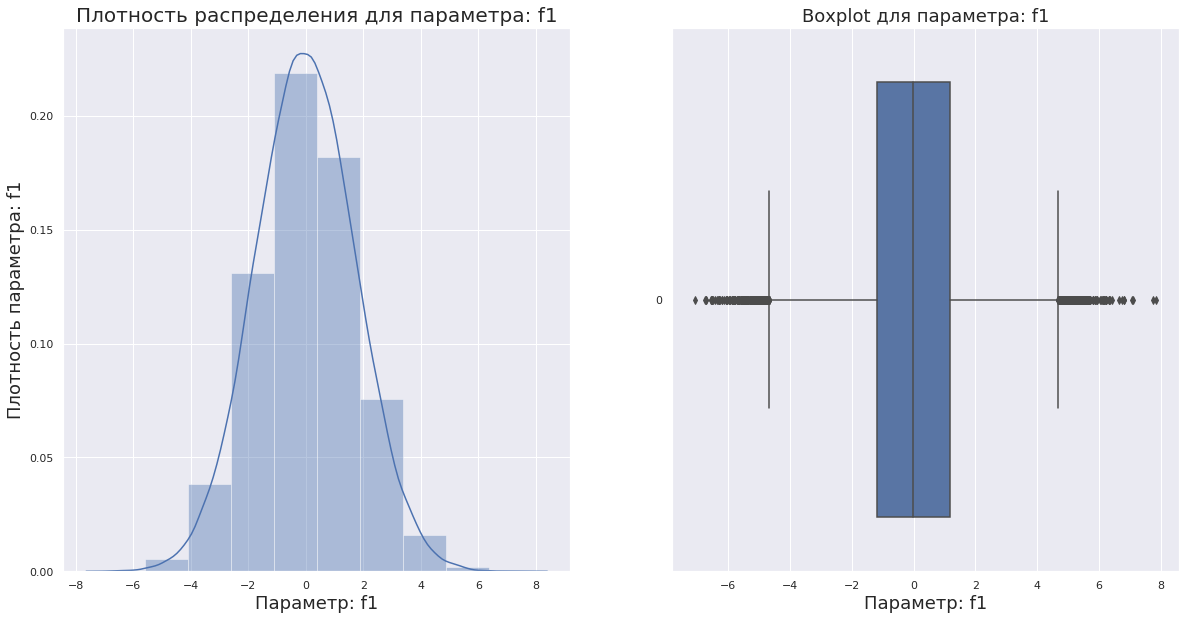

Доля выбросов параметра f1 равно: 0.68%
Анализ параметра 'f2':


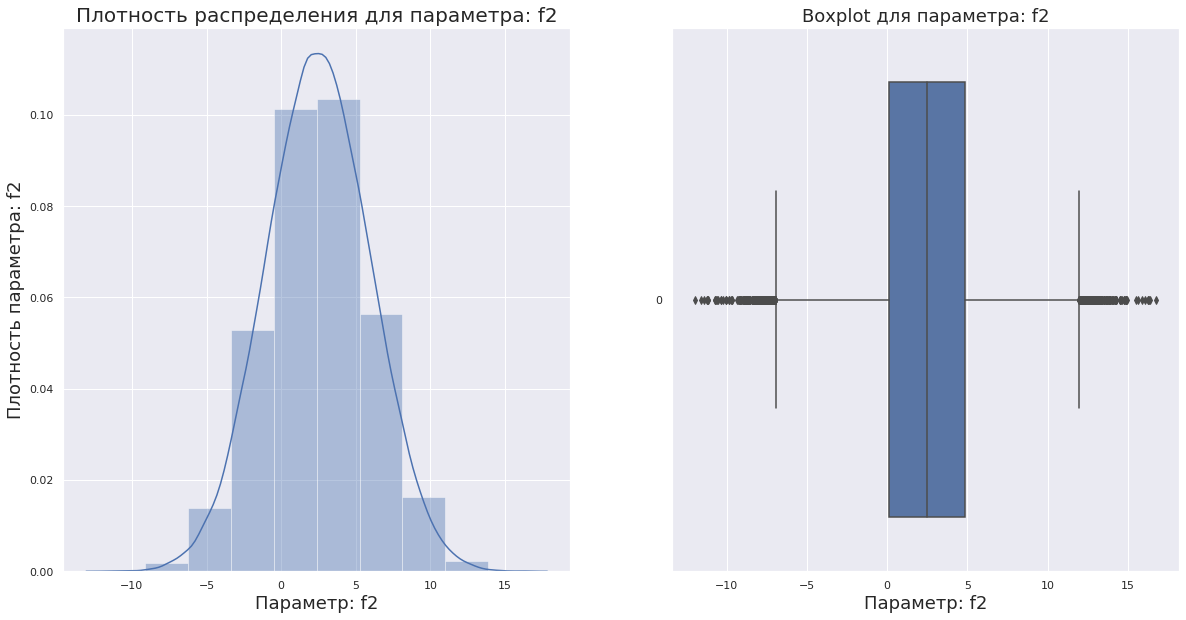

Доля выбросов параметра f2 равно: 0.58%
Анализ параметра 'product':


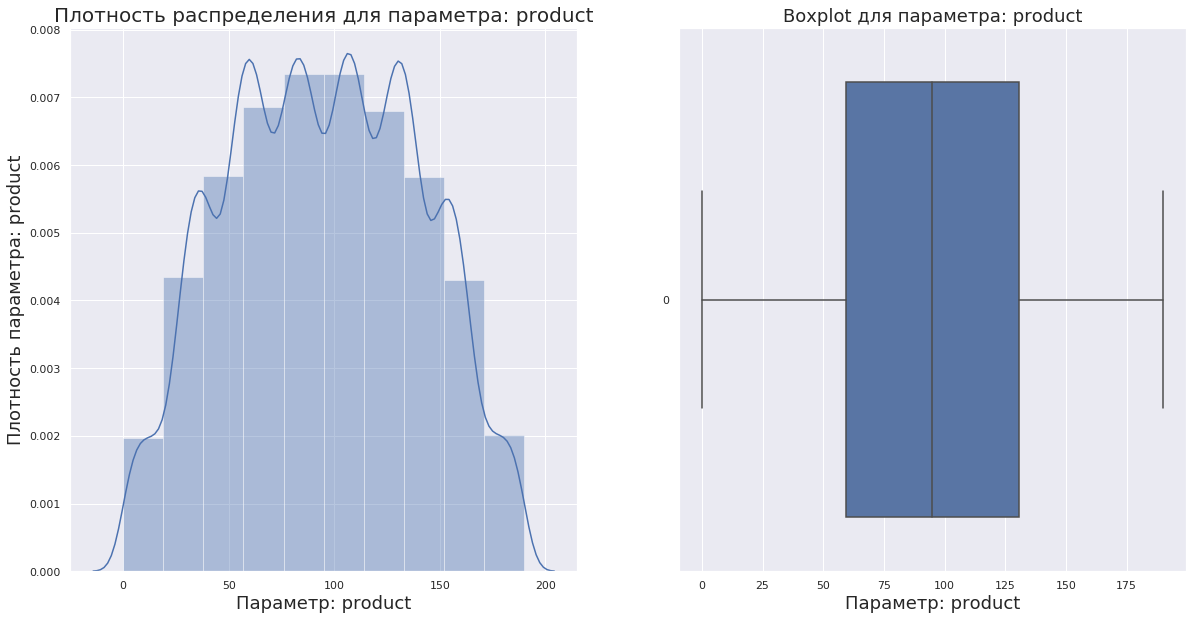

Доля выбросов параметра product равно: 0.0%


In [7]:
#вызываем функцию осмотра параметров
dataset_plus_num = [[df0, 0], [df1, 1], [df2, 2]]

for df in dataset_plus_num:
    check_param(10, df[0], df[1])

Присутствуют небольшие выбросы (до 1%). Видны как нормальные, так и ненормальные распределения. Признаки отличаются по абсолютным границам, необходимо применить масштабирование.

Вывод по пункту 1:

- Каждый датасет (отдельно взятый регион) содержит 100 000 наблюдений. Пропусков, дубликатов нет. Формат данных корректен. 

- По целевому признаку product среднеквадратическое отклонение примерно равны, минимумы = 0, максимумы для 0 и 2 месторождения примерно равны, а по месторождению 1 ниже. Также среднее и медианы для месторождений 0 и 2 примерно равны, а по месторождению 1 среднее больше медианы.

- Заметна корреляция между признаком f2 и целевым признаком product. Между признаками f0 f1 f2 корреляция незначительна. Для месторождение №1 - околоединичная положительная корреляция между f2-product.

- Присутствуют небольшие выбросы (до 1%) в данных. По признакам видны как нормальные, так и ненормальные распределения.

- Данные готовы для разделения и масштабирования.

## Обучение и проверка модели

Напишем функцию 

1) деления данных на обучающую и валидационную выборку (3:1), 

2) обучения модели, 

3) сохранения ответов на валидационной выборке и 

4) оценка среднего запаса предсказанного сырья и RMSE. Сохраним данные по предсказаниям и ответам для будущего расчета прибыли.

In [8]:
def model_preparator(df):
    #выделяем признаки и целевой признак
    features = df[['f0', 'f1', 'f2']]
    target = df[['product']]
    #выделяем обучающие и валидационные выборки
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    print("Размер обучающей выборки, признаки и ответы: ", features_train.shape, "и ", target_train.shape)
    print("Размер валидационной выборки, признаки и ответы: ", features_valid.shape, "и ", target_valid.shape)
    #масштабируем данные
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid= scaler.transform(features_valid)
    
    print("После разделения и масштабирования, первые пять строк обучающей выборки:")
    print(pd.DataFrame(features_train).head(5))
    
    #создаем и обучаем модель
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    
    #оцениваем модель
    predictions_mean = predictions.mean()
    model_rmse = mean_squared_error(target_valid, predictions)**0.5
    
    print("Средний объем нефти: {:.3f} тыс. баррелей".format(predictions_mean))
    print("RMSE модели: {:.3f}".format(model_rmse))
    
    return target_valid, predictions

**Месторождение №0**

In [9]:
target_valid_0, predictions_0 = model_preparator(df0)

Размер обучающей выборки, признаки и ответы:  (75000, 3) и  (75000, 1)
Размер валидационной выборки, признаки и ответы:  (25000, 3) и  (25000, 1)
После разделения и масштабирования, первые пять строк обучающей выборки:
          0         1         2
0 -0.544828  1.390264 -0.094959
1  1.455912 -0.480422  1.209567
2  0.260460  0.825069 -0.204865
3 -1.837105  0.010321 -0.147634
4 -1.299243  0.987558  1.273181
Средний объем нефти: 92.593 тыс. баррелей
RMSE модели: 37.579


**Месторождение №1**

In [10]:
target_valid_1, predictions_1 = model_preparator(df1)

Размер обучающей выборки, признаки и ответы:  (75000, 3) и  (75000, 1)
Размер валидационной выборки, признаки и ответы:  (25000, 3) и  (25000, 1)
После разделения и масштабирования, первые пять строк обучающей выборки:
          0         1         2
0 -0.850855  0.624428  0.296943
1  1.971935  1.832275  0.294333
2  1.079305  0.170127 -0.296418
3 -1.512028 -0.887837 -0.880471
4 -1.804775 -0.718311 -0.293255
Средний объем нефти: 68.729 тыс. баррелей
RMSE модели: 0.893


**Месторождение №2**

In [11]:
target_valid_2, predictions_2 = model_preparator(df2)

Размер обучающей выборки, признаки и ответы:  (75000, 3) и  (75000, 1)
Размер валидационной выборки, признаки и ответы:  (25000, 3) и  (25000, 1)
После разделения и масштабирования, первые пять строк обучающей выборки:
          0         1         2
0 -0.526160  0.776329 -0.400793
1 -0.889625 -0.404070 -1.222936
2 -1.133984  0.208576  0.296765
3  1.227045  1.570166 -0.764556
4 -0.194289  0.878312  0.840821
Средний объем нефти: 94.965 тыс. баррелей
RMSE модели: 40.030


Вывод по пункту 2:

- Разделили данные, обучили модель, применили масштабирование, выявили средний объем нефти (тыс баррелей) для скважин трех месторождений (тыс баррелей). 

- Средний объем запасов в скважине для месторождения 0 (92.6 тыс бар) и 2 (94.9 тыс бар) больше, чем для месторождения 1 (68.7 тыс бар). 
- Однако, RMSE среднеквадратичное отклонение модели для месторождения 0 (37.6) и 2 (40) также выше, чем для месторождения 1 (<1). Следовательно, модель предсказания более неточна для месторождений 0 и 2.

## Подготовка к расчёту прибыли

Количество скважин (N = 200) * объём сырья для безубыточной разработки новой скважины (min_product) * цена единицы сырья (C = 450 тыс / тыс бар нефти) = Бюджет (B = 10^10 руб)

Или математически:

B = N * C * min_product => **min_product = B / (NC)**

In [12]:
B = 10**10
N = 200
C = 450 * 1000

In [13]:
min_product = B/N/C
print("Объем сырья для безубыточной разработки новой скважины: {:.3f} тыс. баррелей нефти".format(min_product))

Объем сырья для безубыточной разработки новой скважины: 111.111 тыс. баррелей нефти


По условиям задачи исследуются 500 скважин, а уже из них выбираются лучшие 200

In [14]:
N_all = 500

Вывод по пункту 3:

- Объем сырья для безубыточной разработки новой скважины: 111.111 тыс баррелей нефти
- Важно отметить, что средние показатели по месторождениям 0 (92.6 тыс бар), 1 (68.7 тыс бар) и 2 (94.9 тыс бар) меньше данного показателя (111.1 тыс бар). То есть случайный выбор проектных скважин - не лучшее решение при разработке месторождения. **Это говорит о необходимости отбора скважин с большими показателями объема сырья, например, с помощью предсказания модели машинного обучения.**

## Расчёт прибыли и рисков 

In [15]:
#функция определения добычи
def well_200_revenue(target, product_pred, count):
    
    product_sorted = product_pred.sort_values(ascending=False)
    selected = target[product_sorted.index][:count]
    
    return selected.sum() * C - B

In [16]:
#применим технику Bootstrap для нахождения средней прибыли
def risk_bootstraped_average(target, predictions):
    
    state = np.random.RandomState(12345)
    risk_threshold = 2.5

    target = pd.Series(target['product']).reset_index(drop=True)
    predictions = pd.Series(map(lambda x: x[0], predictions))
    
    values = []
    lower_upper = {}

    for i in range(1000):
        target_subsample = target.sample(frac = 500 / len(target), replace = True, random_state = state)
        predictions_subsample = predictions[target_subsample.index] 
        values.append(well_200_revenue(target_subsample, predictions_subsample, 200))

    values = pd.Series(values)


    lower_upper['lower'] = values.quantile(0.025)
    lower_upper['upper'] = values.quantile(0.975)
    earnings = values.mean()
    risks = (values < 0).mean() * 100

    print("Доверительный интервал прибыли [{0:.3f} - {1:.3f}]".format((lower_upper['lower']), lower_upper['upper']))
    print("Средняя прибыль: {:.3f}".format(earnings))
    print("Риски: {:.2f} %".format(risks))
    
    if (risks < risk_threshold):
        print("Риск < 2.5%, регион добычи может быть принят к рассмотрению")
    else:
        print("Риск > 2.5%, регион не может быть принят к рассмотрению")

**Месторождение №0**

In [17]:
risk_bootstraped_average(target_valid_0, predictions_0)

Доверительный интервал прибыли [-102090094.838 - 947976353.358]
Средняя прибыль: 425938526.911
Риски: 6.00 %
Риск > 2.5%, регион не может быть принят к рассмотрению


**Месторождение №1**

In [18]:
risk_bootstraped_average(target_valid_1, predictions_1)

Доверительный интервал прибыли [68873225.371 - 931547591.257]
Средняя прибыль: 515222773.443
Риски: 1.00 %
Риск < 2.5%, регион добычи может быть принят к рассмотрению


**Месторождение №2**

In [19]:
risk_bootstraped_average(target_valid_2, predictions_2)

Доверительный интервал прибыли [-128880547.330 - 969706954.180]
Средняя прибыль: 435008362.783
Риски: 6.40 %
Риск > 2.5%, регион не может быть принят к рассмотрению


Вывод по пункту 4:
    
- Написали функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
- Применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков для всех трех регионов. 


- По доверительному интервалу прибыли (68 873 225 -  931 547 591 руб) и рискам (1% < 2.5%) подходит только первый регион добычи. Средняя потенциальная прибыль 435 008 362 руб. **Регион/Местородение №1 можно порекомендовать для разработки.**

## Общий вывод

- Каждый датасет (отдельно взятый регион) содержит 100 000 наблюдений. Пропусков, дубликатов нет. Формат данных корректен. 
- Заметна корреляция между признаком f2 и целевым признаком product. Между признаками f0 f1 f2 корреляция незначительна. Для месторождение №1 - околоединичная положительная корреляция между f2-product.
- Присутствуют небольшие выбросы (до 1%) в данных. По признакам видны как нормальные, так и ненормальные распределения.

- Средний объем запасов в скважине для месторождения 0 (92.6 тыс бар) и 2 (94.9 тыс бар) больше, чем для месторождения 1 (68.7 тыс бар). 
- Однако, RMSE среднеквадратичное отклонение модели для месторождения 0 (37.6) и 2 (40) также выше, чем для месторождения 1 (<1). Следовательно, модель предсказания более неточна для месторождений 0 и 2.

- Объем сырья для безубыточной разработки новой скважины: 111.111 тыс баррелей нефти
- Важно отметить, что средние показатели по месторождениям 0 (92.6 тыс бар), 1 (68.7 тыс бар) и 2 (94.9 тыс бар) меньше данного показателя (111.1 тыс бар). То есть случайный выбор проектных скважин - не лучшее решение при разработке месторождения. **Это говорит о необходимости отбора скважин с большими показателями объема сырья, например, с помощью предсказания модели машинного обучения.**

- По доверительному интервалу прибыли (68 873 225 -  931 547 591 руб) и рискам (1% < 2.5%) подходит только первый регион добычи. Средняя потенциальная прибыль 435 008 362 руб. **Регион/Местородение №1 можно порекомендовать для разработки.**